In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [23]:
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import pyro
from torch import nn
import pyro.distributions as dist
from pyro.infer import HMC, MCMC, SVI, NUTS, TraceMeanField_ELBO
from pyro import poutine
from sklearn.datasets import load_boston
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from rec.utils import kl_estimate_with_mc
import matplotlib.pyplot as plt


In [5]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

In [6]:
import numpy as np
import pandas as pd
np.random.seed(0)
# np.random.seed(0)
# !wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0).iloc[:, :10].values

In [7]:
x_ = data[:, :-2]
y_ = data[:, -2:]

In [8]:
test_splits_idxs = []
for d in range(x_.shape[-1]):
    sorted_x = np.argsort(x_[:,d], axis=-1)
    total_points = sorted_x.shape[0]
    lower_third = total_points // 3
    upper_third = total_points * 2 // 3
    test_index = sorted_x[lower_third: upper_third]
    test_splits_idxs.append(test_index)

In [9]:
test_splits_x, test_splits_y = [], []
train_splits_x, train_splits_y = [], []
for d in range(x_.shape[-1]):
    a = np.arange(x_.shape[0])
    test_index = test_splits_idxs[d]
    train_index = np.delete(a, test_index, axis=0)
    x_train = x_[train_index]
    y_train = y_[train_index]
    x_test = x_[test_index][:]
    y_test = y_[test_index][:]
    x_m = x_train.mean(0)
    x_s = x_train.std(0)
    x_train = (x_train - x_m) / x_s
    x_test = (x_test - x_m) / x_s
    test_splits_x.append(x_test)
    test_splits_y.append(y_test)
    train_splits_x.append(x_train)
    train_splits_y.append(y_train)

In [10]:
D_in = x_train.shape[-1]
D_out = y_test.shape[-1]
x_train = torch.FloatTensor(np.array(train_splits_x))
y_train = torch.FloatTensor(np.array(train_splits_y))
x_test= torch.FloatTensor(np.array(test_splits_x))
y_test = torch.FloatTensor(np.array(test_splits_y))

In [11]:
def regression_model(x, y=None, weight_samples=None, in_size=1, num_nodes=10, out_size=1, ELBO_BETA=1.):
    # sample vector of weights for regression
    total_weights = (in_size + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * out_size
    # sample params
    with poutine.scale(scale=ELBO_BETA):
        params = pyro.sample("params", dist.Normal(torch.zeros(total_weights + D_out), 1.).to_event(1))
    weights, rho = params[:-D_out], params[-D_out:]

    idx = 0
    fc1_weights = weights[idx: idx + in_size * num_nodes].reshape(num_nodes, in_size)
    idx += in_size * num_nodes
    fc1_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc2_weights = weights[idx: idx + num_nodes * num_nodes].reshape(num_nodes, num_nodes)
    idx += num_nodes * num_nodes
    fc2_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc3_weights = weights[idx: idx + num_nodes * out_size].reshape(out_size, num_nodes)
    idx += num_nodes * out_size
    fc3_bias = weights[idx: idx + out_size].reshape(out_size)
    idx += out_size

    assert idx == total_weights, "Something wrong with number of weights!"

    # compute forward pass
    batch_shape = x.shape[0]
    x = torch.einsum("ij, kj -> ki", fc1_weights, x) + fc1_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc2_weights, x) + fc2_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc3_weights, x) + fc3_bias[None].repeat(batch_shape, 1)
    mu = x.squeeze()

    with pyro.plate("data"):
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=mu, 
                                                         covariance_matrix=torch.diag(F.softplus(rho) ** 2)), obs=y)
    return mu

In [12]:
def make_empirical_gmm(samples, num_nodes, x_test):
    rho_noise = samples['params'][:, -D_out:]
    noise = F.softplus(rho_noise) ** 2
    preds_dict = Predictive(regression_model, samples, return_sites=['_RETURN'])(x_test, None, num_nodes=num_nodes,
                                                                                 in_size=D_in, out_size=D_out)
    preds = preds_dict['_RETURN']
    mix = dist.Categorical(torch.ones(preds.shape[0]))
    comp = dist.MultivariateNormal(loc=preds.squeeze().permute(1, 0, 2), covariance_matrix=torch.diag_embed(noise))
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm

def compute_rmse(samples, num_nodes, x_test, y_test):
    preds_dict = Predictive(regression_model, samples, return_sites=['_RETURN'])(x_test, None, num_nodes=num_nodes,
                                                                                 in_size=D_in, out_size=D_out)
    preds = preds_dict['_RETURN']
    mean_preds = preds.mean(0)
    return (mean_preds - y_test).sum(-1).mean().sqrt()

In [13]:
from pyro.infer import Predictive

In [14]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + np.log(K + 1) + 1

# Load Compressed Weights

In [15]:
# model architecture
num_nodes = 3

In [16]:
compressed_emp_test_results = {}
compressed_emp_test_results['test_ll'] = np.empty(D_in,)
compressed_emp_test_results['RMSE'] = np.empty(D_in,)
for s in range(D_in):
    # load specific split
    split_samples = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/compressed_emp_samples_split{s}.pkl", "rb"))
    
    # compute lls on test data
    test_ll = make_empirical_gmm(split_samples, num_nodes=num_nodes, x_test=x_test[s]).log_prob(y_test[s]).mean().item()
    compressed_emp_test_results['test_ll'][s] = test_ll
    compressed_emp_test_results['RMSE'][s] = compute_rmse(split_samples, num_nodes, x_test[s], y_test[s]).item()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


In [17]:
compressed_emp_train_results = {}
compressed_emp_train_results['train_ll'] = np.empty(D_in,)
compressed_emp_train_results['RMSE'] = np.empty(D_in,)
for s in range(D_in):
    # load specific split
    split_samples = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/compressed_emp_samples_split{s}.pkl", "rb"))
    
    # compute lls on train data
    train_ll = make_empirical_gmm(split_samples, num_nodes=num_nodes, x_test=x_train[s]).log_prob(y_train[s]).mean().item()
    compressed_emp_train_results['train_ll'][s] = train_ll
    compressed_emp_train_results['RMSE'][s] = compute_rmse(split_samples, num_nodes, x_train[s], y_train[s]).item()

In [18]:
compressed_kde_test_results = {}
compressed_kde_test_results['test_ll'] = np.empty(D_in,)
compressed_kde_test_results['RMSE'] = np.empty(D_in,)
kde_kls = np.empty(D_in,)
for s in range(D_in):
    # load specific split
    split_samples = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/compressed_kde_samples_split{s}.pkl", "rb"))
    
    # compute lls on test data
    test_ll = make_empirical_gmm(split_samples, num_nodes=num_nodes, x_test=x_test[s]).log_prob(y_test[s]).mean().item()
    compressed_kde_test_results['test_ll'][s] = test_ll
    compressed_kde_test_results['RMSE'][s] = compute_rmse(split_samples, num_nodes, x_test[s], y_test[s]).item()
    
    # load kls
    kde_kls[s] = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/kde_kl_split{s}.pkl", "rb"))

In [19]:
compressed_kde_train_results = {}
compressed_kde_train_results['train_ll'] = np.empty(D_in,)
compressed_kde_train_results['RMSE'] = np.empty(D_in,)
for s in range(D_in):
    # load specific split
    split_samples = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/compressed_kde_samples_split{s}.pkl", "rb"))
    
    # compute lls on train data
    train_ll = make_empirical_gmm(split_samples, num_nodes=num_nodes, x_test=x_train[s]).log_prob(y_train[s]).mean().item()
    compressed_kde_train_results['train_ll'][s] = train_ll
    compressed_kde_train_results['RMSE'][s] = compute_rmse(split_samples, num_nodes, x_train[s], y_train[s]).item()

In [20]:
compressed_var_test_results = {}
compressed_var_test_results['test_ll'] = np.empty(D_in,)
compressed_var_test_results['RMSE'] = np.empty(D_in,)
var_kls = np.empty(D_in,)
for s in range(D_in):
    # load specific split
    split_samples = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/compressed_var_samples_split{s}.pkl", "rb"))
    
    # compute lls on test data
    test_ll = make_empirical_gmm(split_samples, num_nodes=num_nodes, x_test=x_test[s]).log_prob(y_test[s]).mean().item()
    compressed_var_test_results['test_ll'][s] = test_ll
    compressed_var_test_results['RMSE'][s] = compute_rmse(split_samples, num_nodes, x_test[s], y_test[s]).item()
    # load kls
    var_kls[s] = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/var_kl_split{s}.pkl", "rb"))

In [24]:
compressed_var_train_results = {}
compressed_var_train_results['train_ll'] = np.empty(D_in,)
compressed_var_train_results['RMSE'] = np.empty(D_in,)
for s in tqdm(range(D_in)):
    # load specific split
    split_samples = pkl.load(open(f"PickledStuff/BNN_UCI/ENERGY/compressed_var_samples_split{s}.pkl", "rb"))
    
    # compute lls on train data
    train_ll = make_empirical_gmm(split_samples, num_nodes=num_nodes, x_test=x_train[s]).log_prob(y_train[s]).mean().item()
    compressed_var_train_results['train_ll'][s] = train_ll
    compressed_var_train_results['RMSE'][s] = compute_rmse(split_samples, num_nodes, x_train[s], y_train[s]).item()

  0%|          | 0/8 [00:00<?, ?it/s]

In [25]:
emp_test_ll_mean = compressed_emp_test_results['test_ll'].mean()
emp_test_std_error = compressed_emp_test_results['test_ll'].std() / len(compressed_emp_test_results['test_ll'])

kde_test_ll_mean = compressed_kde_test_results['test_ll'].mean()
kde_test_std_error = compressed_kde_test_results['test_ll'].std() / len(compressed_kde_test_results['test_ll'])

var_test_ll_mean = compressed_var_test_results['test_ll'].mean()
var_test_std_error = compressed_var_test_results['test_ll'].std() / len(compressed_var_test_results['test_ll'])

In [26]:
emp_train_ll_mean = compressed_emp_train_results['train_ll'].mean()
emp_train_std_error = compressed_emp_train_results['train_ll'].std() / len(compressed_emp_train_results['train_ll'])

kde_train_ll_mean = compressed_kde_train_results['train_ll'].mean()
kde_train_std_error = compressed_kde_train_results['train_ll'].std() / len(compressed_kde_train_results['train_ll'])

var_train_ll_mean = compressed_var_train_results['train_ll'].mean()
var_train_std_error = compressed_var_train_results['train_ll'].std() / len(compressed_var_train_results['train_ll'])

In [27]:
coding_eff_kde = compute_expected_coding_efficiency(kde_kls)
coding_eff_var = compute_expected_coding_efficiency(var_kls)

In [28]:
coding_eff_kde_mean = coding_eff_kde.mean()
coding_eff_kde_std_error = coding_eff_kde.std() / len(coding_eff_kde)

In [29]:
coding_eff_var_mean = coding_eff_var.mean()
coding_eff_var_std_error = coding_eff_var.std() / len(coding_eff_var)

In [30]:
kde_kls_mean =  kde_kls.mean()
kde_kls_std_error = kde_kls.std() / len(kde_kls)

In [31]:
var_kls_mean =  var_kls.mean()
var_kls_std_error = var_kls.std() / len(var_kls)

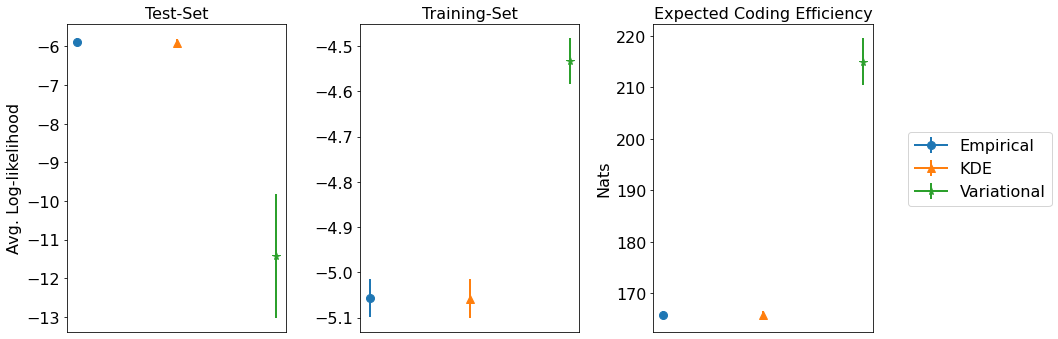

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12.5,5), sharex=True)
fs=16
ax1.errorbar([0], emp_test_ll_mean, yerr=emp_test_std_error, marker='o', markersize=8)
ax1.errorbar([1], kde_test_ll_mean, yerr=kde_test_std_error, marker='^', markersize=8)
ax1.errorbar([2], var_test_ll_mean, yerr=var_test_std_error, marker='*', markersize=8)
ax2.errorbar([0], emp_train_ll_mean, yerr=emp_train_std_error, marker='o', markersize=8)
ax2.errorbar([1], kde_train_ll_mean, yerr=kde_train_std_error, marker='^', markersize=8)
ax2.errorbar([2], var_train_ll_mean, yerr=var_train_std_error, marker='*', markersize=8)
ax3.errorbar([0], coding_eff_kde_mean, yerr=coding_eff_kde_std_error, marker='o', markersize=8)
ax3.errorbar([1], coding_eff_kde_mean, yerr=coding_eff_kde_std_error, marker='^', markersize=8)
ax3.errorbar([2], coding_eff_var_mean, yerr=coding_eff_var_std_error, marker='*', markersize=8)
ax1.xaxis.set_ticks_position('none') 
ax2.xaxis.set_ticks_position('none') 
ax3.xaxis.set_ticks_position('none') 
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['', '', ''], fontsize=fs)
ax1.set_ylabel('Avg. Log-likelihood', fontsize=fs)
ax3.set_ylabel('Nats', fontsize=fs)
ax1.set_title('Test-Set', fontsize=fs)
ax2.set_title('Training-Set', fontsize=fs)
ax3.set_title('Expected Coding Efficiency', fontsize=fs)
f.legend(['Empirical', 'KDE', 'Variational'], fontsize=fs, bbox_to_anchor=(1.1, 0.5), loc='center')
f.tight_layout()
f.savefig("Figures/Thesis/BNN_UCI.pdf", bbox_inches='tight')